In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

<a name='2'></a>
Load and Split the Data

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

Text(0.5, 1.0, 'Segmentation')

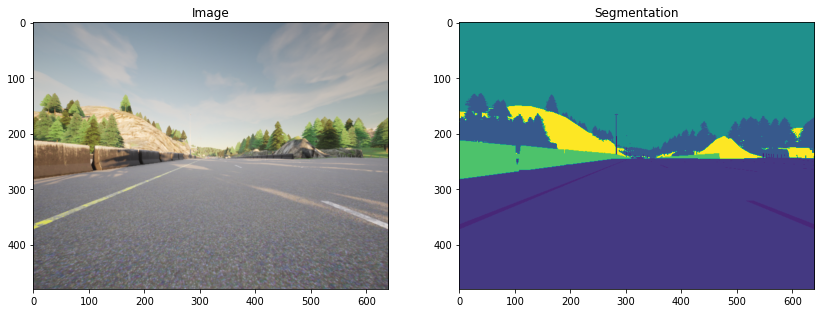

In [ ]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-1'></a>
Split Your Dataset into Unmasked and Masked Images

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/002128.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/002128.png', shape=(), dtype=string)


In [ ]:
dataset.take(1)

<TakeDataset shapes: ((), ()), types: (tf.string, tf.string)>

<a name='2-2'></a>
Preprocess Data

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2, padding='same')(conv)   
    else:
        next_layer = conv
        
    skip_connection = conv
    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    return conv

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes,1, padding='same')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

<a name='3-5'></a>
Set Model Dimensions

In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

Model: "functional_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 96, 128, 32)  896         input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 96, 128, 32)  9248        conv2d_88[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_23 (MaxPooling2D) (None, 48, 64, 32)   0           conv2d_89[0][0]                  
______________________________________________________________________________________

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


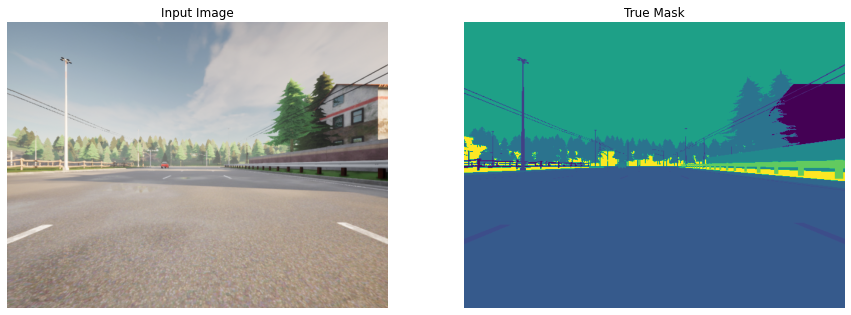

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


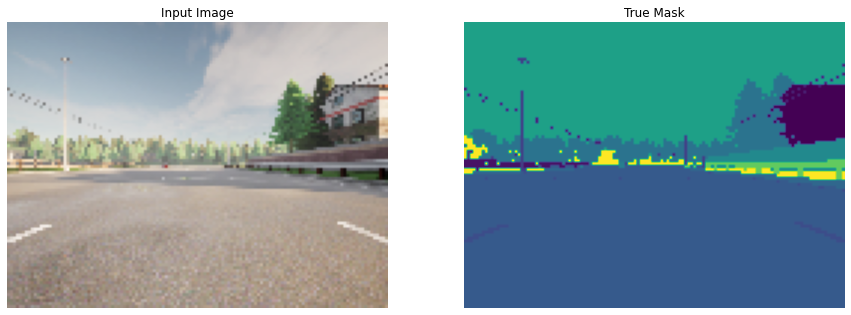

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
Train the Model

In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 [==============================] - 18s 541ms/step - loss: 1.9401 - accuracy: 0.4455
Epoch 2/40
34/34 [==============================] - 1s 40ms/step - loss: 1.0597 - accuracy: 0.7006
Epoch 3/40
34/34 [==============================] - 1s 40ms/step - loss: 0.6323 - accuracy: 0.8300
Epoch 4/40
34/34 [==============================] - 1s 40ms/step - loss: 0.5036 - accuracy: 0.8611
Epoch 5/40
34/34 [==============================] - 1s 40ms/step - loss: 0.4133 - accuracy: 0.8789
Epoch 6/40
34/34 [==============================] - 1s 40ms/step - loss: 0.3742 - accuracy: 0.8895
Epoch 7/40
34/34 [==============================] - 1s 40ms/step - loss: 0.3492 - accuracy: 0.8972
Epoch 8/40
34/34 [==============================] - 1s 40ms/step - loss: 0.3251 - accuracy: 0.9037
Epoch 9/40
34/34 [==============================] - 1s 41ms/step - loss: 0.2654 - acc

<a name='4-1'></a>
Create Predicted Masks 

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

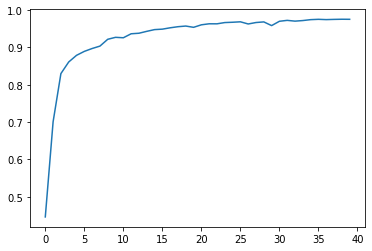

In [ ]:
plt.plot(model_history.history["accuracy"])

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

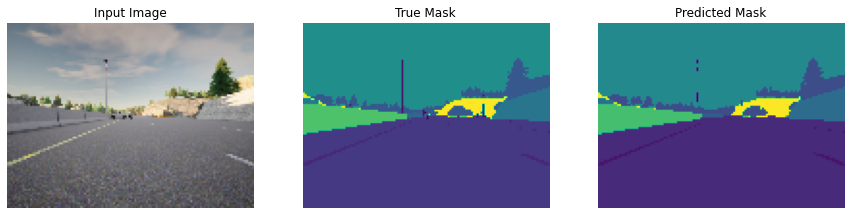

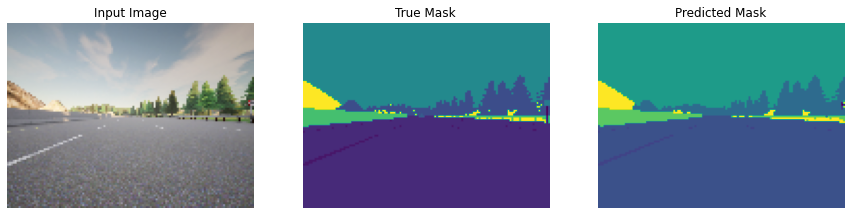

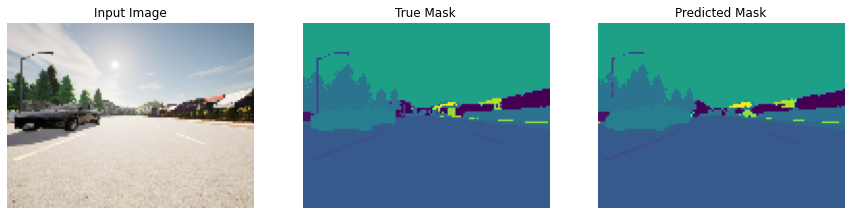

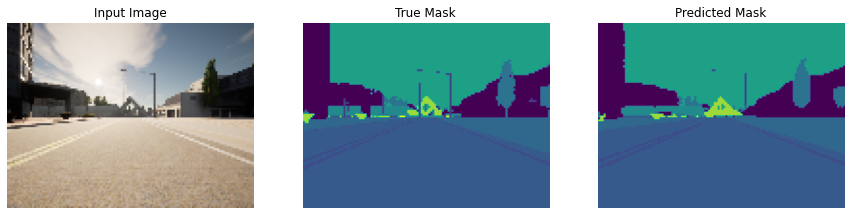

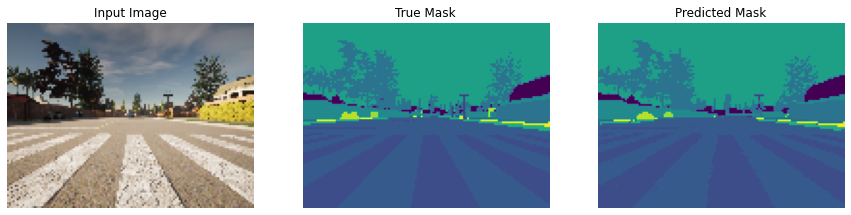

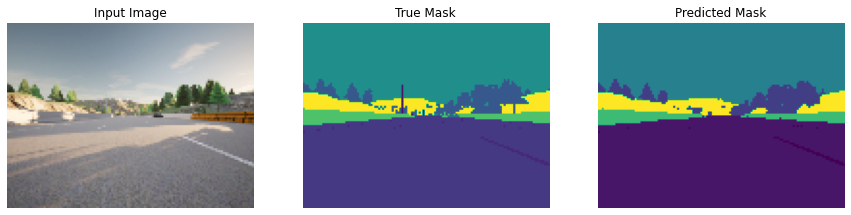

In [ ]:
show_predictions(train_dataset, 6)